<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-데이터-로드" data-toc-modified-id="1.-데이터-로드-1">1. 데이터 로드</a></span></li><li><span><a href="#2.-수요지점-좌표-리스트-생성" data-toc-modified-id="2.-수요지점-좌표-리스트-생성-2">2. 수요지점 좌표 리스트 생성</a></span></li><li><span><a href="#3.-MCLP-구현" data-toc-modified-id="3.-MCLP-구현-3">3. MCLP 구현</a></span></li></ul></div>

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
from itertools import zip_longest   # zip 함수 길이 다를 경우
from haversine import haversine

## 1. 데이터 로드

In [2]:
# 석관동
입지후보지 = pd.read_csv('./data/입지선정후보군_좌표추가.csv', encoding='EUC-KR')
입지후보지 = 입지후보지[입지후보지['행정동'] == '석관동']
print(입지후보지.shape)
입지후보지.head(2)

(9, 6)


,분류,시설명,x좌표,y좌표,법정동,행정동
0,간이운동장,돌 뫼,127.052763,37.605125,석관동,석관동
5,간이운동장,샛 별,127.064140,37.614111,석관동,석관동


In [3]:
버스 = pd.read_csv('./data/서울시_버스정류장_행정동추가.csv')
버스 = 버스[버스['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                 '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(버스.shape)
버스.head(2)

(197, 7)


,정류소명,X좌표,Y좌표,정류버스수,행정동,행정동_경도,행정동_위도
120,석계역,127.067231,37.615065,25,석관동,127.061437,37.612982
149,한진한화그랑빌아파트,127.069914,37.618255,23,월계3동,127.069259,37.621015


In [4]:
지하철 = pd.read_csv('./data/서울시_지하철역_행정동추가.csv', encoding='EUC-KR', index_col=0)
지하철 = 지하철[지하철['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                       '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(지하철.shape)
지하철.head(2)

(12, 14)


,전철역코드,전철역명,전철명명(영문),호선,외부코드,검색키워드,주소,위도,경도,환승역,H/B,행정동,행정동_경도,행정동_위도
164,2642,월곡역,Wolgok,6호선,641,월곡역 6호선,서울 성북구 월곡로 지하 107,37.601421,127.041185,0,H,월곡2동,127.047886,37.605792
165,2643,상월곡역,Sangwolgok,6호선,642,상월곡역 6호선,서울 성북구 화랑로 지하 157,37.606264,127.048327,0,H,월곡2동,127.047886,37.605792


In [5]:
주차장 = pd.read_csv('./data/서울시_주차장_행정동추가.csv', encoding='EUC-KR', index_col=0).drop('Unnamed: 0.1', axis=1)
주차장 = 주차장[주차장['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                       '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(주차장.shape)
주차장.head(2)

(27, 9)


,주차장id,주차장이름,주소,경도,위도,H/B,행정동,행정동_경도,행정동_위도
331,26535897,회기동공영주차장,서울 동대문구 회기동 1-1,127.055785,37.591502,H,회기동,127.055372,37.590789
332,2085355453,회기동공영주차장 전기차충전소,서울 동대문구 이문동 340-1,127.055959,37.591342,H,회기동,127.055372,37.590789


In [21]:
주택 = pd.read_csv('./data/서울시_주택_행정동추가.csv', encoding='EUC-KR')
주택 = 주택[주택['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                 '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(주택.shape)
주택.head(2)

(18, 12)


,구명,단지명,주택유형,세대수,주소,우편번호,경도,위도,H/B,행정동,행정동_경도,행정동_위도
157,노원구,공릉1,영구임대,1395,동일로 1127 (공릉동 공릉1단지아파트),1851,127.069855,37.629590,H,공릉1동,127.073821,37.624836
158,노원구,월계사슴1,영구임대,1372,월계로 372 (월계동 월계사슴1단지아파트),1905,127.059664,37.629247,H,월계3동,127.069259,37.621015


## 2. 수요지점 좌표 리스트 생성

In [8]:
버스_points = np.array([list(i) for i in zip(버스['X좌표'], 버스['Y좌표'])])
print(버스_points.shape)
버스_points[:2]

(197, 2)


array([[127.06723071,  37.61506526],
       [127.069914  ,  37.61825517]])

In [9]:
지하철_points = np.array([list(i) for i in zip(지하철['경도'], 지하철['위도'])])
print(지하철_points.shape)
지하철_points[:2]

(12, 2)


array([[127.04118477,  37.60142105],
       [127.04832662,  37.60626414]])

In [10]:
주차장_points = np.array([list(i) for i in zip(주차장['경도'], 주차장['위도'])])
print(주차장_points.shape)
주차장_points[:2]

(27, 2)


array([[127.05578514,  37.59150199],
       [127.05595939,  37.59134243]])

In [12]:
주택_points = np.array([list(i) for i in zip(주택['경도'], 주택['위도'])])
print(주택_points.shape)
주택_points[:2]

(18, 2)


array([[127.0698548 ,  37.62958967],
       [127.0596641 ,  37.62924721]])

In [13]:
X = list(버스['X좌표']) + list(지하철['경도']) + list(주차장['경도']) + list(주택['경도'])
X[:2]

[127.06723070700001, 127.0699139994]

In [14]:
Y = list(버스['Y좌표']) + list(지하철['위도']) + list(주차장['위도']) + list(주택['위도'])
Y[:2]

[37.6150652627, 37.6182551734]

In [15]:
points = np.array([list(i) for i in zip(X, Y)])
print(points.shape)
points[:2]

(254, 2)


array([[127.06723071,  37.61506526],
       [127.069914  ,  37.61825517]])

## 3. MCLP 구현

- 반경을 m 단위로 조절하기 위해 haversine 라이브러리를 활용하여 거리 계산


- 수요지점별 개수의 불균형 해소를 위해 가중치를 부여할 수 있도록 목적함수 수정

In [16]:
def mclp(버스_points, 지하철_points, 주차장_points, 주택_points, points, K, radius):
    """
    Solve maximum covering location problem
    Input:
        points: 수요지점 좌표 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
    J = sites.shape[0]
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주차장_points.shape[0]
    D = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산 (haversine으로 수정)
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)     # 단위를 m로 변경하기 위해 *1000
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D2.append(site)
    D2 = np.array(D2)    
    
    D3 = []
    for i in 주차장_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D3.append(site)
    D3 = np.array(D3)
    
    D4 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D4.append(site)
    D4 = np.array(D4)
    
    for i in [D1, D2, D3, D4]:
        mask1 = i<=radius
        i[mask1]=1                                         
        i[~mask1]=0

    m = Model()
    x1, x2, x3, x4 = {}, {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    for i in range(D):                                       
        x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K)

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    for i in range(D): 
        m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])

    # 목적함수 수정
    m.setObjective(quicksum(i for i in [1*x1[a] for a in range(A)] + [1*x2[b] for b in range(B)] + [1*x3[c] for c in range(C)] + [1*x4[d] for d in range(D)]),\
                   GRB.MAXIMIZE)     # 1 대신 가중치 입력
    
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [17]:
opts_sites, mobjVal = mclp(버스_points, 지하철_points, 주차장_points, 주택_points, points, 3, 300)
opts_sites

  Number of points 254
  K 3
  Radius 300
Restricted license - for non-production use only - expires 2022-01-13
----- Output -----
  Running time : 0.0713505744934082 seconds
  Optimal coverage points: 26


array([[127.052763,  37.605125],
       [127.063579,  37.614357],
       [127.054559,  37.608453]])

In [18]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [19]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

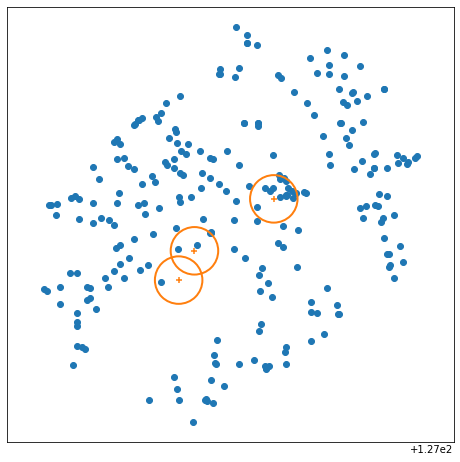

In [20]:
plot_result(points, opts_sites, 0.0027)